# Stream Clustering

In [2]:
from scripts.preprocess_data import *
from scripts.preprocess_lemmatizer import preprocess_lemmatizer
from river import cluster
from river import stream
from river import feature_extraction
from river import compose
import nltk
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arneh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = load_data()
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df['minute_of_day'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
length = df.shape[0]
df_sub = df.iloc[:length]


In [4]:
preprocessed_text_sub = [ preprocess_lemmatizer(tweet)for tweet in df_sub['text']]


In [46]:
text_clust_algo = cluster.TextClust(real_time_fading=False, fading_factor=0.001, tgap=100, auto_r=False,
    radius=0.9, num_macro = 10)

stopwords = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I']

In [47]:
model = compose.Pipeline(
    feature_extraction.BagOfWords(lowercase=True, ngram_range=(1, 2), stop_words=stopwords),
    text_clust_algo,
)

### Variable log [(minute_of_day_1,[(microcluster_id_1, microcluster_weight_1), (microcluster_id_x, microcluster_weight_x)]), (minute_of_day_x,[(microcluster_id_1, microcluster_weight_1), (microcluster_id_x, microcluster_weight_x)])]

In [84]:
import pandas as pd


text_clust_algo = cluster.TextClust(real_time_fading=False, fading_factor=0.001, tgap=100, auto_r=False,
    radius=0.8, num_macro = 10)

stopwords = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I']


model = compose.Pipeline(
    feature_extraction.BagOfWords(lowercase=True, ngram_range=(1, 2), stop_words=stopwords),
    text_clust_algo,
)

nstart = 0
i = 0
old_time = df_sub.loc[i, 'minute_of_day']
log = []
micro_clusters = text_clust_algo.micro_clusters
print("running")

for text in preprocessed_text_sub:
    if i % 5000 == 0:
        print(f"Iteration: {nstart+i}")

    if df_sub.loc[i, 'minute_of_day'] == 600:
        print(text_clust_algo.showclusters(topn=10,num=10))

    model.learn_one(text)
    if df_sub.loc[i, 'minute_of_day'] != old_time:
        old_time = df_sub.loc[i, 'minute_of_day']
        micro_clusters = text_clust_algo.micro_clusters
        for key, micro_cluster in micro_clusters.items():

            if "unims" in micro_cluster.tf:
                print(nstart+i, micro_cluster.id ,list(micro_cluster.tf.items())[:5], micro_cluster.weight)

            weight = micro_cluster.weight
            log.append({'minute_of_day': old_time, 'micro_cluster_id': key, 'weight': weight, 'terms': [term[0] for term in list(micro_cluster.tf.items())[:20]]})
    i += 1

log_df = pd.DataFrame(log)




running
Iteration: 0
Iteration: 5000
Iteration: 10000
Iteration: 15000
Iteration: 20000
Iteration: 25000
Iteration: 30000
Iteration: 35000
-------------------------------------------
Summary of micro clusters:
----
micro cluster id 23
micro cluster weight 162.01673346068625
weight: 177.36	 token: yhawkins
weight: 119.06	 token: vote
weight: 78.47	 token: let
weight: 75.92	 token: btsbbmas
weight: 62.89	 token: top
weight: 61.29	 token: artist
weight: 61.03	 token: bbmas
weight: 60.48	 token: voting
weight: 58.37	 token: show
weight: 56.82	 token: social
----
micro cluster id 28
micro cluster weight 53.31875533560695
weight: 66.66	 token: science
weight: 11.59	 token: check
weight: 9.32	 token: math
weight: 8.48	 token: stem
weight: 7.79	 token: research
weight: 7.43	 token: world
weight: 7.17	 token: let
weight: 6.8	 token: ('science', 'math')
weight: 5.14	 token: get
weight: 5.11	 token: essay
----
micro cluster id 1
micro cluster weight 52.25540425429385
weight: 69.12	 token: politic

In [81]:
log_df.head()

,minute_of_day,micro_cluster_id,weight
0,1,0,2.962838
1,1,1,11.475528
2,1,2,1.000000
3,1,3,1.000000
4,1,4,1.000000


In [79]:
top_10_microclusters = log_df[log_df['minute_of_day'] == log_df['minute_of_day'].max()].nlargest(10, 'weight')
important_microcluster_ids_at_end = top_10_microclusters['micro_cluster_id'].values


high_weight_ids = log_df[log_df['weight'] > 80]['micro_cluster_id'].unique().tolist()
high_weight_ids


[1, 23, 18, 8, 239, 14062]

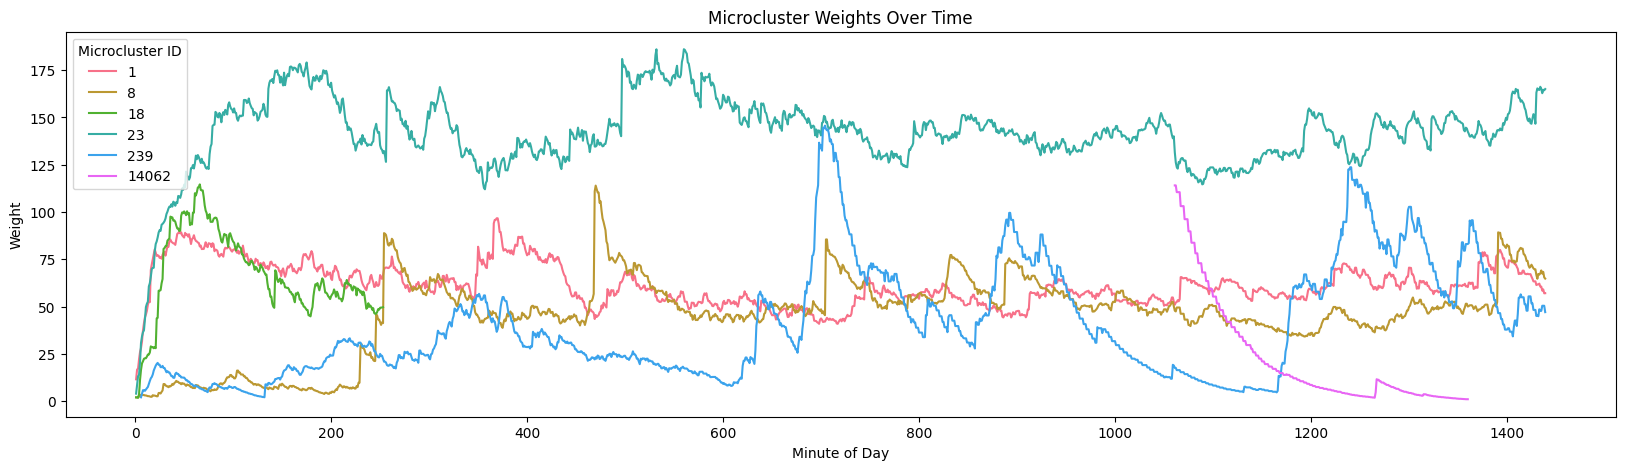

In [80]:
import seaborn as sns

# Filter the log_df for the important microcluster ids
filtered_log_df = log_df[log_df['micro_cluster_id'].isin(high_weight_ids)]

# Plot the data
plt.figure(figsize=(20, 5))
palette = sns.color_palette("husl", len(high_weight_ids))
sns.lineplot(data=filtered_log_df, x='minute_of_day', y='weight', hue='micro_cluster_id', palette=palette)

plt.xlabel('Minute of Day')
plt.ylabel('Weight')
plt.title('Microcluster Weights Over Time')
plt.legend(title='Microcluster ID')
plt.show()


In [55]:
text_clust_algo.showclusters(topn=10,num=10)

-------------------------------------------
Summary of micro clusters:
----
micro cluster id 0
micro cluster weight 420.00610110270975
weight: 273.14	 token: health
weight: 144.48	 token: business
weight: 59.91	 token: mental
weight: 55.11	 token: ('mental', 'health')
weight: 51.12	 token: check
weight: 39.25	 token: healthcare
weight: 35.98	 token: dont
weight: 31.99	 token: science
weight: 30.89	 token: need
weight: 30.72	 token: time
----
micro cluster id 4
micro cluster weight 253.26174977132337
weight: 192.89	 token: yhawkins
weight: 138.29	 token: vote
weight: 87.88	 token: let
weight: 78.02	 token: top
weight: 77.84	 token: artist
weight: 74.28	 token: btsbbmas
weight: 71.43	 token: bbmas
weight: 71.09	 token: social
weight: 67.18	 token: ('social', 'artist')
weight: 66.1	 token: ('top', 'social')
----
micro cluster id 5030
micro cluster weight 97.92801092540113
weight: 93.37	 token: politics
weight: 11.87	 token: let
weight: 11.63	 token: truss
weight: 10.34	 token: political
w

In [53]:
text_clust_algo.updateMacroClusters()
macroclust = text_clust_algo.get_macroclusters()
macroclust
print('done')

done


In [16]:
log[len(log)-1][1][0]

(0, 92.920232933458)

In [ ]:
log[14]

In [47]:
complete_linkage_stream_clust = linkage(distance_matrix,method='ward')

C:\Users\Simon.Luttmann\AppData\Local\Temp\ipykernel_18152\3172585452.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  complete_linkage_stream_clust = linkage(distance_matrix,method='ward')


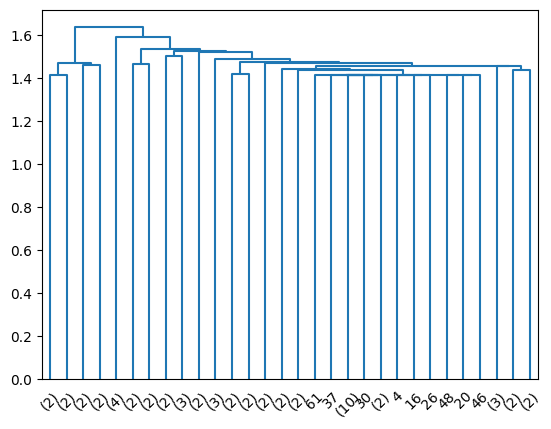

In [49]:
dendrogram(complete_linkage_stream_clust, truncate_mode='lastp', p=30)
plt.show()

In [54]:
threshold = 1.5
#6.3  # Replace with the value identified from the dendrogram
clusters = fcluster(complete_linkage_stream_clust, t=threshold, criterion='distance')
clusters[:]

array([1, 1, 2, 7, 7, 3, 6, 7, 7, 3, 7, 4, 4, 5, 1, 5, 7, 7, 3, 6, 7, 1,
       2, 1, 7, 3, 7, 7, 7, 5, 7, 7, 7, 2, 1, 1, 2, 7, 1, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
      dtype=int32)

In [16]:
text_clust_algo._agglomerative_clustering()

-------------------------------------------
Summary of micro clusters:
----
micro cluster id 0
micro cluster weight 490.25358925561653
weight: 88.32	 token: health
weight: 73.25	 token: politics
weight: 68.8	 token: business
-------------------------------------------


In [ ]:
text_clust_algo.learn_one(preprocessed_text_list_of_dicts[0])
text_clust_algo.micro_clusters

TypeError: can't multiply sequence by non-int of type 'float'